In [ ]:
pip install torch

In [1]:
## Analyze the selected song data and prepare it for the model 
## This notebook is used to prepare the data for the model. It is not used in the model itself. 
## The data is prepared in the following steps:
## 1. Load the data

## load the midi files from the songs folder 

import os 
import glob 
import pickle 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import music21 as m21

from tqdm import tqdm
from music21 import converter, instrument, note, chord, stream
from keras.utils import np_utils
import json
import IPython.display
from datetime import datetime
import random

import torch
import torch.nn as nn
from torch.nn import functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from tqdm.notebook import tqdm, trange

import random
import itertools

c:\Users\JingHong Huang\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\JingHong Huang\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\JingHong Huang\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [ ]:

!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install music21
!pip install pypianoroll

## Getting the Lakh MIDI Dataset ##

source: https://nbviewer.org/github/craffel/midi-dataset/blob/master/Tutorial.ipynb 

In [1]:
import os 
# Local path constants
DATA_PATH = 'data'
RESULTS_PATH = '.'
# Path to the file match_scores.json distributed with the LMD
SCORE_FILE = os.path.join(RESULTS_PATH, 'match_scores.json')

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def msd_id_to_mp3(msd_id):
    """Given an MSD ID, return the path to the corresponding mp3"""
    return os.path.join(DATA_PATH, 'msd', 'mp3',
                        msd_id_to_dirs(msd_id) + '.mp3')

def msd_id_to_h5(msd_id):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(RESULTS_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

def get_midi_path(msd_id, midi_md5, kind):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file.
    kind should be one of 'matched' or 'aligned'. """
    return os.path.join(RESULTS_PATH, 'lmd_{}'.format(kind),
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

In [2]:
with open(SCORE_FILE) as f:
    scores = json.load(f)
# Grab a Million Song Dataset ID from the scores dictionary
msd_id = scores.keys()
msd_id = list(msd_id)
print(len(msd_id))

NameError: name 'json' is not defined

## Installation stuff ## 


In [19]:
## Installation stuff ## 

!pip install -q git+https://github.com/tensorflow/docs
!pip install llvmlite --ignore installed 
!pip install tensorflow-addons
!pip install --upgrade --ignore-installed tensorflow
!pip -q imageio
!pip install librosa 
!pip install tensorflow
!pip install numba==0.53 --user


In [2]:
import librosa

import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers 

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

AUTOTUNE = tf.data.experimental.AUTOTUNE

c:\Users\JingHong Huang\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [4]:
train_size = 60000
BATCH_SIZE = 10
test_size = 10000
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 10

BASE_PATH = '../swifty-music/metadata/genres_original'

## Data Preprocessing ##


In [5]:
def DatasetLoader(class_):
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    train_music_1 = list(music_list[[0,52,19,39,71,12,75,85,3,45,24,46,88]]) #99,10,66,76,41
    train_music_2 = list(music_list[[4,43,56,55,45,31,11,13,70,37,21,78]]) #65,32,53,22,19,80,89,
    TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_1]
    TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_2]

    return TrackSet_1, TrackSet_2

In [6]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30)
    # originally 90001
    data_ = data_.reshape(1,90001)
    return data_
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

In [7]:
TrackSet_1, TrackSet_2 = DatasetLoader('jazz')

## Sample an original music ##

In [9]:
sample = TrackSet_1[1]
sample_, sampling_rate = librosa.load(sample,sr=3000, offset=0.0, duration=30)
ipd.Audio(sample_,rate=3000)

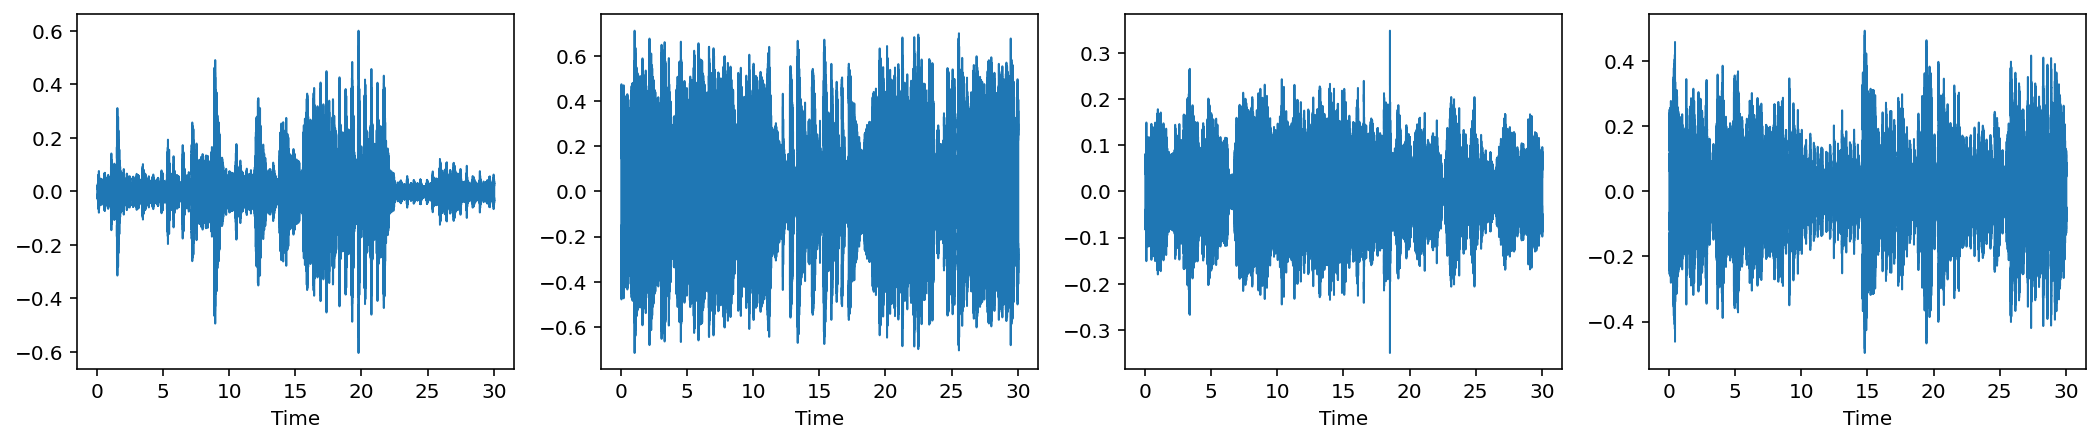

In [10]:
# waveplot is NOW waveshow
import librosa.display
plt.figure(figsize=(18,15))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    j = load(TrackSet_1[i])
    librosa.display.waveshow(j[0], sr=3000)

In [12]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

## Network Architecture ##  

In [13]:
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters,type='encode'):
        # super(Resnet1DBlock, self).init()
        super().__init__()
    
        if type=='encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)

In [14]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,90001)),
                ## 1D Convolutional Layers: strides, dilation_rate, groups 
                layers.Conv1D(64,1,2),
                Resnet1DBlock(64,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(256,1,2),
                Resnet1DBlock(256,1),
                # No activation
                layers.Flatten(),
                layers.Dense(latent_dim+latent_dim)

            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Reshape(target_shape=(1,latent_dim)),
                Resnet1DBlock(512,1,'decode'),
                layers.Conv1DTranspose(512,1,1),
                Resnet1DBlock(256,1,'decode'),
                layers.Conv1DTranspose(256,1,1),
                Resnet1DBlock(128,1,'decode'),
                layers.Conv1DTranspose(128,1,1),
                Resnet1DBlock(64,1,'decode'),
                layers.Conv1DTranspose(64,1,1),
                # No activation
                layers.Conv1DTranspose(90001,1,1),
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [15]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)


In [16]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

In [17]:
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

## Loss Optimization ## 
Using K loss: The KL divergence tells us how well the probability distribution Q approximates the probability distribution P by calculating the cross-entropy minus the entropy. Intuitively, you can think of that as the statistical measure of how one distribution differs from another. In VAE, let X be the data we want to model, z be latent variable, P(X) be the probability distribution of data, P(z) be the probability distribution of the latent variable and P(X|z) be the distribution of generating data given latent variable.

In the case of variational autoencoders, our objective is to infer P(z) from P(z|X). P(z|X) is the probability distribution that projects our data into latent space. But since we do not have the distribution P(z|X), we estimate it using its simpler estimation Q.

Now while training our VAE, the encoder should try to learn the simpler distribution Q(z|X) such that it is as close as possible to the actual distribution P(z|X). This is where we use KL divergence as a measure of a difference between two probability distributions. The VAE objective function thus includes this KL divergence term that needs to be minimized.

DKL[Q(z|X)||P(z|X)] = E[ logQ(z|X) − logP(z|X) ]

## Reconstruction loss ## 
As the name suggest, it measures the reconstruction of original input x. This network can be trained by minimizing the reconstruction error, which measures the differences between our original input and the consequent reconstruction.

In [18]:
@tf.function
def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [19]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [20]:
import librosa.display

def generate_and_save_images(model, epoch, test_sample, save):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        librosa.display.waveshow(wave[0], sr=3000)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.show()

In [21]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

## Training the Model ## 

Epoch: 20, Test set ELBO: -25047.40234375, time elapse for current epoch: 0.38202714920043945


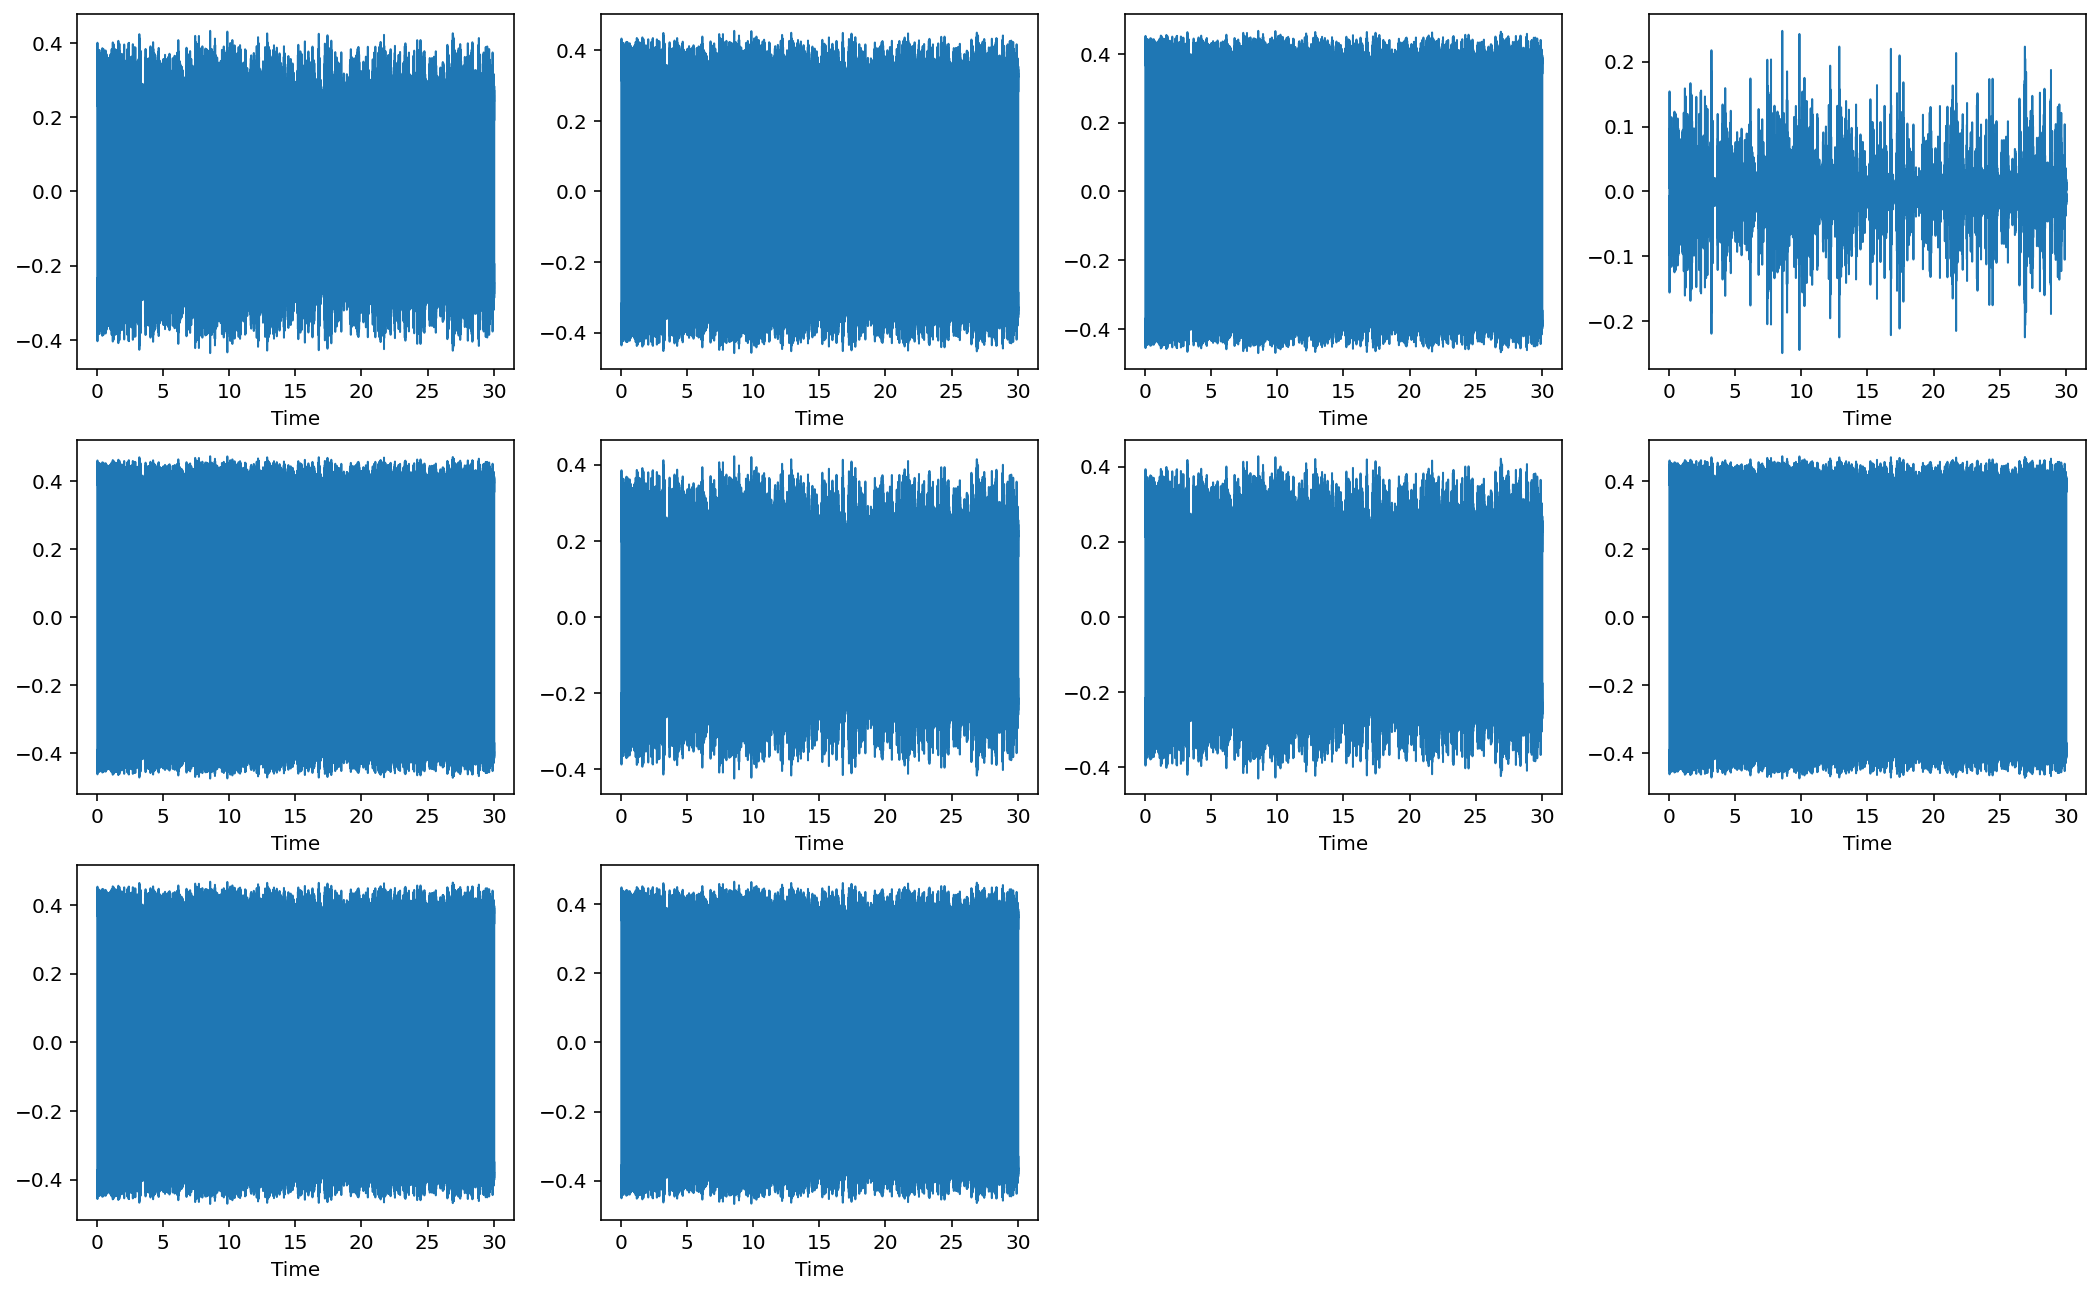

In [22]:
generate_and_save_images(model, 0, test_sample, 'jazz')
def train(train_dataset, test_dataset, model, save):
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_x = np.asarray(train_x)[0]
            train_step(model, train_x, optimizer)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            test_x = np.asarray(test_x)[0]
            loss(compute_loss(model, test_x))
        display.clear_output(wait=False)
        elbo = -loss.result()
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, 
                                                                                       elbo, 
                                                                                       end_time - start_time
                                                                                      ))
        generate_and_save_images(model,
                                 epoch, 
                                 test_sample,
                                 save)
train(train_dataset, test_dataset, model, 'jazz')

In [23]:
anim_file_1 = 'jazz_cvae.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('jazz*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

## Training The Model Using Taylor Swift Music ##

## could try to denoise and get rid of the lyrics in the data ** 

In [24]:
def load_and_adjust_audio(audio_path, desired_sequence_length):
    """
    Load an audio file and adjust its length to match the desired sequence length.

    Parameters:
        audio_path (str): Path to the audio file.
        desired_sequence_length (int): Desired sequence length for padding or truncation.

    Returns:
        adjusted_audio (np.ndarray): Audio data with adjusted length.
    """
    sample_ts_, sampling_rate = librosa.load(audio_path, sr=3000, duration=30)

    if sample_ts_.shape[0] > desired_sequence_length:
        # Truncate the audio if it's longer than the desired sequence length
        adjusted_audio = sample_ts_[:desired_sequence_length]
    else:
        # Pad the audio if it's shorter than the desired sequence length
        pad_width = desired_sequence_length - sample_ts_.shape[0]
        # rather than padding it with zeros, we pad it with the the content of the audio itself 
        adjusted_audio  = np.pad(sample_ts_, (0, pad_width), mode='wrap') 
        # adjusted_audio = np.pad(sample_ts_, (0, pad_width), mode='constant', constant_values=0)

    return adjusted_audio

In [25]:
def DataSetLoaderTS(class_):
    '''generate the two training set for Taylor Swift Melody training'''
    # music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+'pop'))) 
    ts_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_))) 
    # randomly select 80 songs from pop music
    # random_list = random.sample(range(0, 100), 80) 
    # randomly select half of the songs from ts_list 
    random_list_ts = random.sample(range(0, len(ts_list)), len(ts_list)//2)
    # train_music_1 = list(music_list[random_list]) 
    ts_music_1 = list(ts_list[random_list_ts]) 
    # train_music_1.extend(ts_music) 

    # train_music_2 = list(music_list[[x for x in range(0,100) if x not in random_list]]) 
    # train_music_2.extend(ts_list[[x for x in range(0,len(ts_list)) if x not in random_list_ts]])
    ts_music_2 = list(ts_list[[x for x in range(0,len(ts_list)) if x not in random_list_ts]])

    TrackSet_1 = [(BASE_PATH)+'/'+'TS_wav'+'/%s'%(x) for x in ts_music_1]
    TrackSet_2 = [(BASE_PATH)+'/'+'TS_wav'+'/%s'%(x) for x in ts_music_2]
    return TrackSet_1, TrackSet_2 

def load_ts(file_): 
    ''' load the data set from the TS_file'''
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30) 
    # call the load_and_adjust_audio function to adjust the length of the audio 
    data_ = load_and_adjust_audio(file_, 90001)
    data_ = data_.reshape(1,90001)
    return data_
map_data_ts = lambda filename: tf.compat.v1.py_func(load_ts, [filename], [tf.float32]) 



In [26]:
TrackSet_1_TS, TrackSet_2_TS = DataSetLoaderTS('TS_wav')

In [27]:
sample_ts = TrackSet_1_TS[1] 
sample_ts_, sampling_rate = librosa.load(sample_ts,sr=3000, offset=0.0, duration=30) 
ipd.Audio(sample_ts_,rate=3000)

In [28]:
train_dataset_ts = ( 
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1_TS))
    .map(map_data_ts, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset_ts = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2_TS))
    .map(map_data_ts, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)


Epoch: 20, Test set ELBO: -12663.6123046875, time elapse for current epoch: 0.6951429843902588


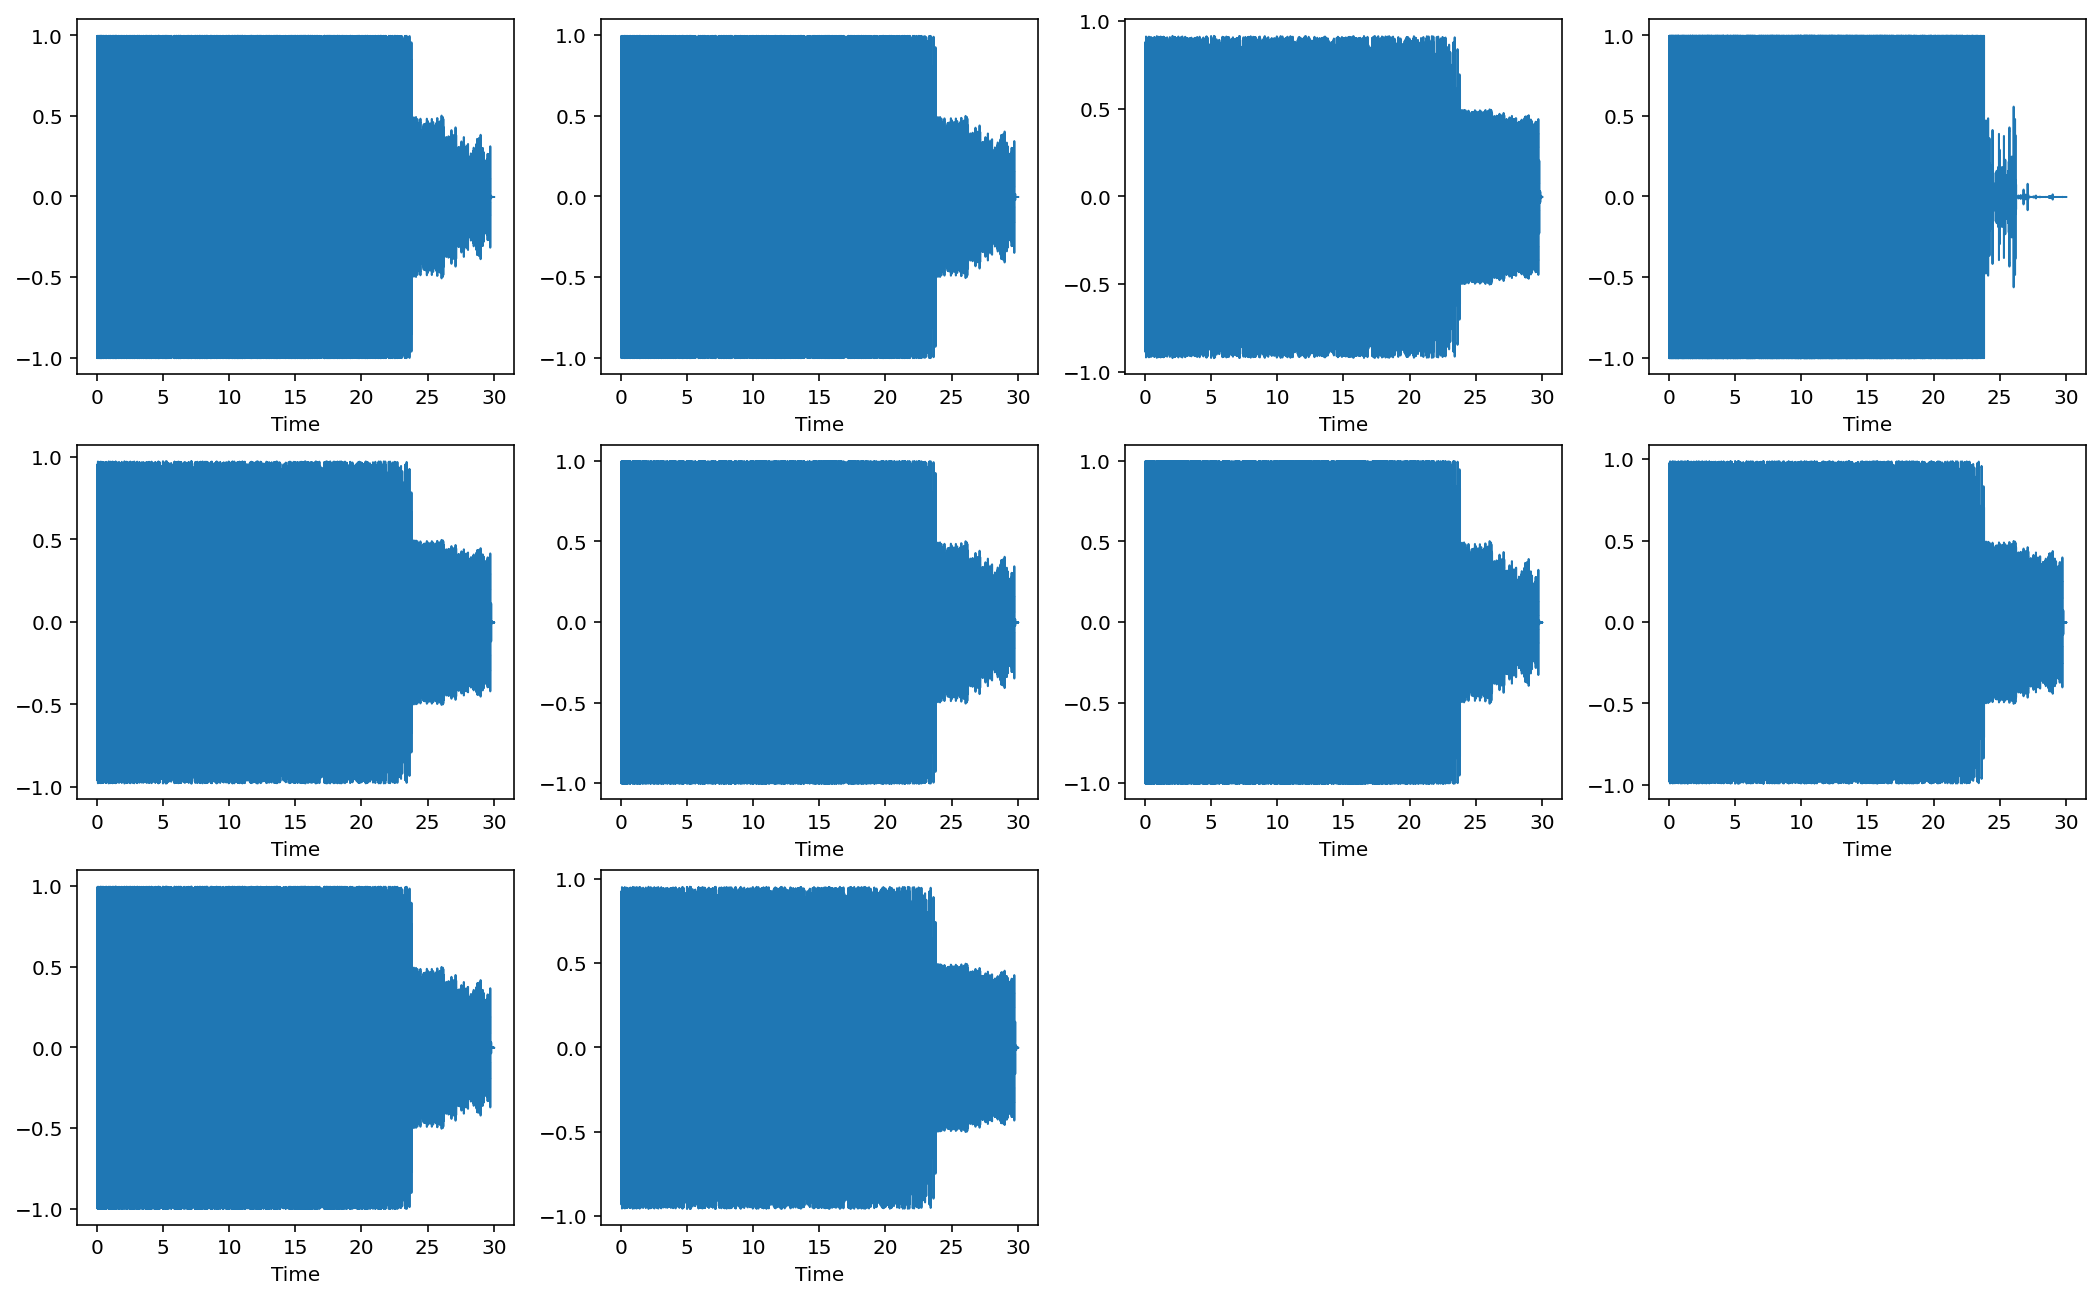

In [29]:
generate_and_save_images(model, 0, test_sample, 'Ts_wav')
def train_ts(train_dataset_ts, test_dataset_ts, model, save): 
    for epoch in range(1 , epochs + 1):
        start_time = time.time()
        for train_x in train_dataset_ts: 
            train_x = np.asarray(train_x)[0] 
            train_step(model, train_x, optimizer)
        end_time = time.time()
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset_ts: 
            test_x = np.asarray(test_x)[0] 
            loss(compute_loss(model, test_x))
        display.clear_output(wait=False)
        elbo = -loss.result()
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, 
                                                                                        elbo, 
                                                                                        end_time - start_time
                                                                                          ))
        generate_and_save_images(model,
                                    epoch, 
                                    test_sample,
                                    save)
train_ts(train_dataset_ts, test_dataset_ts, model, 'TS_wav')


In [35]:
# test the trained model on the TS_wav data set
anim_file_2 = 'TS_wav_cvae.gif'
with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('TS.wav*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    print('finish')

finish


## Listen to the models ##

In [36]:
def inference(test_dataset, model):  
    save_music = []
    for test in test_dataset:
        mean, logvar = model.encode(test)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        for pred in predictions:
            wave = np.asarray(pred)
            save_music.append(wave)
    return save_music

saved_musics = inference(test_dataset, model)

In [41]:
music1=saved_musics[0][0]
ipd.Audio(music1,rate=3000)